<a href="https://colab.research.google.com/github/aditya-411/options_pricing_using_quantum_computing/blob/main/options_pricing_using_quantum_computing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# European Call Option Pricing Using Quantum Computing
In this project we aim to price European call options using quantum computing with help of Qiskit SDK and then comparing the results with the monte carlo method. The quantum computing based approach gives a quadratic speed-up over the monte carlo method.

## **Importing all the necessary libraries**

In [166]:
# !pip install qiskit
# !pip install qiskit_finance
# !pip install qiskit-aer
# !pip install pylatexenc
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

from qiskit import QuantumCircuit
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit_aer.primitives import Sampler
from qiskit_finance.circuit.library import LogNormalDistribution

## **Settings all the variables for the prediction**

In [167]:
#Set the Variables for the code

num_uncertainty_qubits = 6       # number of qubits to represent the uncertainty for quantum approach
S = 10                           # Set the initial spot price
vol = 0.3                        # Set the volatility where 1 = 100% and 0 = 0%
r = 0.064                        # set annual interest rate where 0.01 = 1%
T = 70 / 365                     # set days to maturity of the option in terms of years
strike_price = 11                # set strike price for the option

N = 10**5                        # no. of simulations in monte carlo approach
M = 500                          # steps per approach in monte carlo approach

## **The Quantum computing approach**

### Calculating log normal probability distribution for spot price at maturity

In [168]:
# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
)

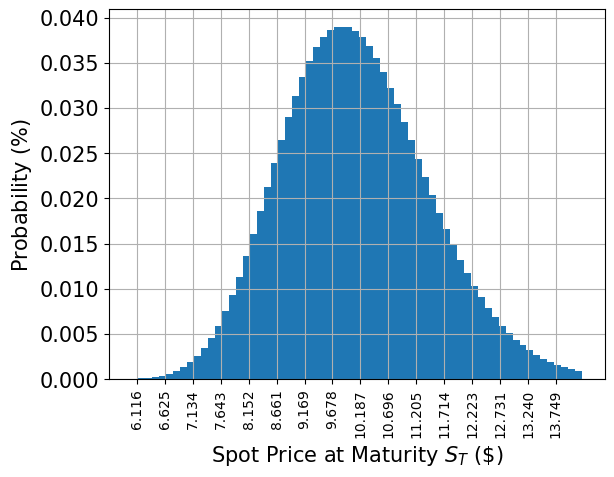

In [169]:
# plot probability distribution

x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.bar(x, y, width=0.2)
plt.xticks(x[::len(x)//13],  rotation='vertical')
plt.yticks(size=15)
plt.grid()
plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.show()

### Making the quantum circuit

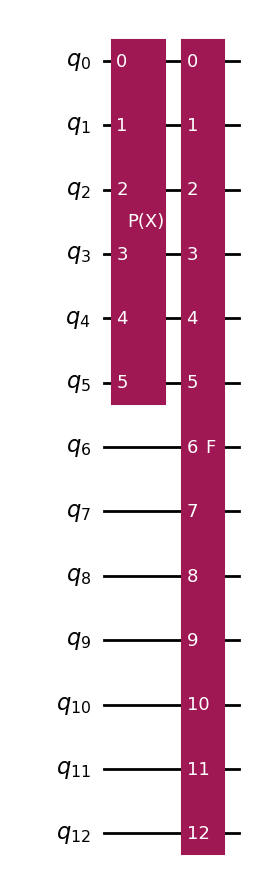

In [170]:
# set the approximation scaling for the payoff function
c_approx = 0.25

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price
european_call_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
num_qubits = european_call_objective.num_qubits
european_call = QuantumCircuit(num_qubits)
european_call.append(uncertainty_model, range(num_uncertainty_qubits))
european_call.append(european_call_objective, range(num_qubits))

# draw the circuit
european_call.draw(output='mpl')

### Plotting pay off function

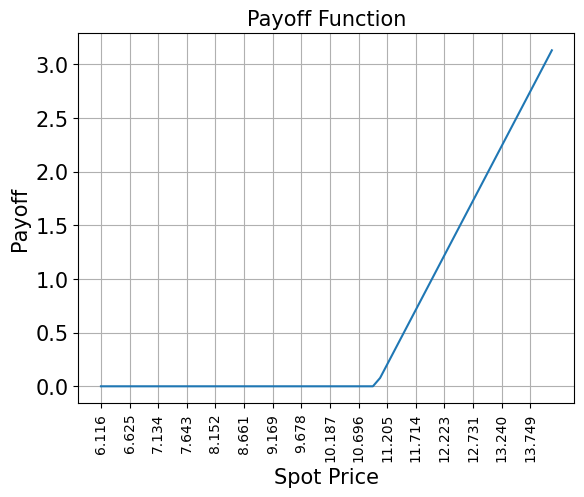

In [171]:
# plot exact payoff function (evaluated on the grid of the uncertainty model)
x = uncertainty_model.values
y = np.maximum(0, x - strike_price)
plt.plot(x, y)
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("Spot Price", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(x[::len(x)//13],  rotation='vertical')
plt.yticks(size=15)
plt.show()

### Getting Expected Pricing

In [172]:
exact_value = np.dot(uncertainty_model.probabilities, y)
exact_delta = sum(uncertainty_model.probabilities[x >= strike_price])
print("exact expected value:\t%.4f" % exact_value)
print("exact delta value:   \t%.4f" % exact_delta)

exact expected value:	0.2068
exact delta value:   	0.2364


In [173]:
epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(
    state_preparation=european_call,
    objective_qubits=[num_uncertainty_qubits],
    post_processing=european_call_objective.post_processing,
)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 200, "seed": 75})
)

In [174]:
# Run the Amplitude estimation
result = ae.estimate(problem)


In [175]:
conf_int = np.array(result.confidence_interval_processed)
print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (result.estimation_processed))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.2068
Estimated value:    	0.2174
Confidence interval:	[0.1790, 0.2559]


## **Monte Carlo Approach**

In [176]:
# Time step
dt = T / M

# Simulate the price paths
path = np.zeros((N, M + 1))
path[:, 0] = S
for t in range(1, M + 1):
    z = np.random.standard_normal(N)   # Generate random variables
    path[:, t] = path[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + vol * np.sqrt(dt) * z)

# Calculate the payoff at maturity
payoff = np.maximum(path[:, -1] - strike_price, 0)

# Discount the payoff to present value
discounted_payoff = np.exp(-r * T) * payoff

# Calculate the option price for increasing number of simulations to show convergence
prices = np.zeros(N)
for i in range(1, N + 1):
    prices[i-1] = np.mean(discounted_payoff[:i])

option_price = prices[-1]
print(f"European Call Option Price: {option_price:.2f}")

European Call Option Price: 0.24


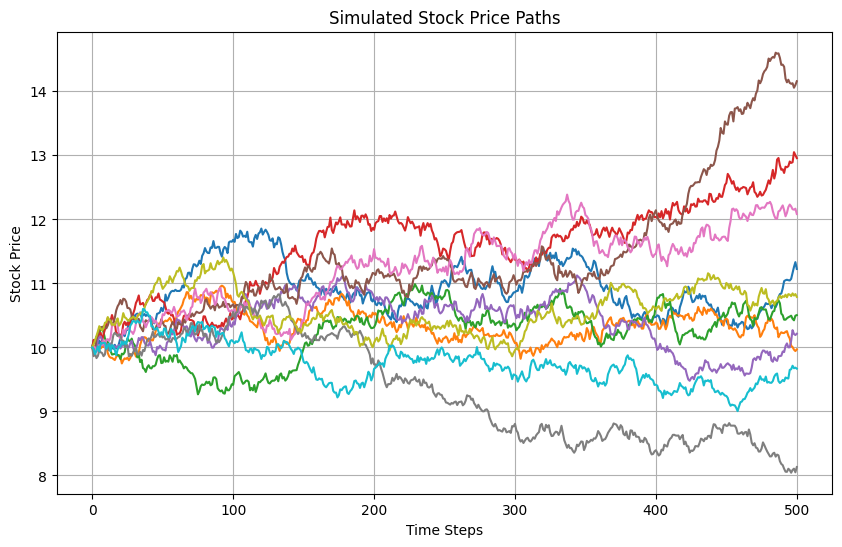

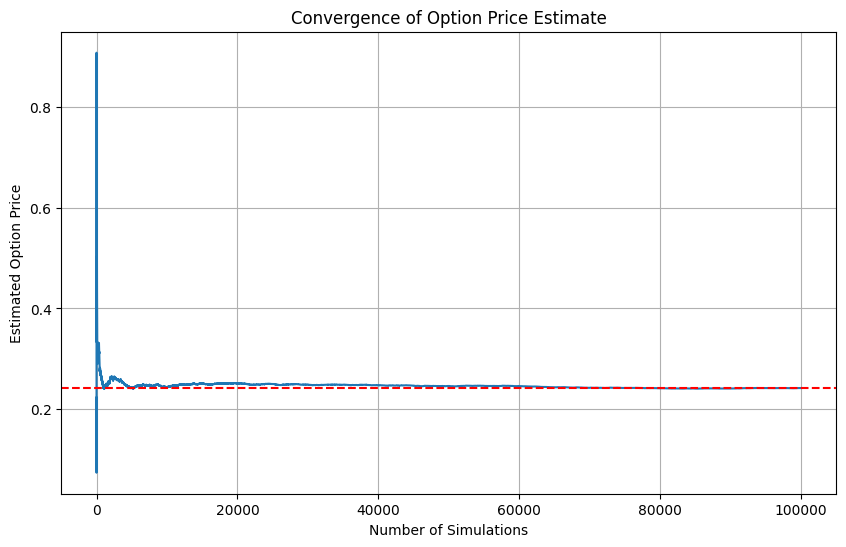

In [181]:
# Plotting some of the simulated price paths
plt.figure(figsize=(10, 6))
for i in range(min(N, 10)):          # Plotting only the first 10 simulations for clarity
    plt.plot(path[i, :], lw=1.5)
plt.title('Simulated Stock Price Paths')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.grid(True)
plt.show()

# Plotting the convergence of the option price
plt.figure(figsize=(10, 6))
plt.plot(prices, lw=1.5)
plt.title('Convergence of Option Price Estimate')
plt.xlabel('Number of Simulations')
plt.ylabel('Estimated Option Price')
plt.grid(True)
plt.axhline(y=option_price, color='r', linestyle='--')
plt.show()

## **Comparing Monte Carlo and Quantum Computing predictions**

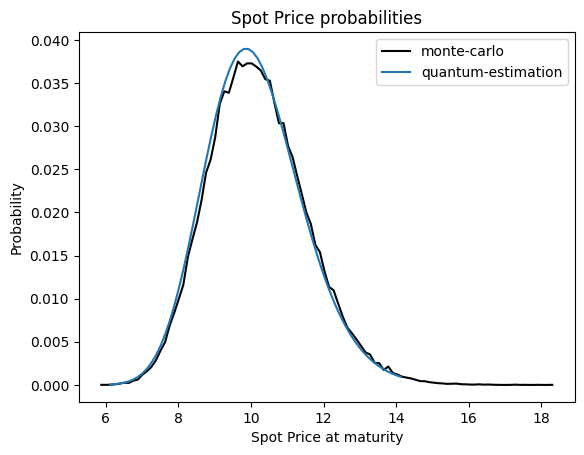

In [179]:
plt.figure()

# Plot the probabilities according to monte carlo
y, binEdges = np.histogram(path[:, -1], bins=100)
bincenters = 0.5 * (binEdges[1:] + binEdges[:-1])
plt.plot(bincenters, y/N, '-', c='black', label="monte-carlo")


# plot the probabilities according to quantum estimation
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.plot(x, y, label="quantum-estimation")


# Set graph labels
plt.title("Spot Price probabilities")
plt.xlabel("Spot Price at maturity")
plt.ylabel("Probability")
plt.legend()


plt.show()